# ENSO_duration: Duration of SST Anomalies in the Central Equatorial Pacific  

Computes the number of months during which sea surface temperature anomalies (SSTA) persist in the Niño3.4 region (horizontal average over 5°S–5°N, 170°W–120°W). This metric evaluates the duration of SST anomalies during the 6 years centred on the peak of ENSO events, comparing model simulations with reference observations.

## Datasets Used for Duration Comparison  

The following reference datasets are used to evaluate the duration of ENSO-related SST anomalies in model simulations:  

- **TropFlux (1979–2018)**: The primary dataset for comparison, designed for analysing tropical climate variability, including surface fluxes and SST anomalies.  

Additional datasets include:  
- **20CRv2 (1871–2012)**: A historical reanalysis product providing long-term atmospheric data using surface pressure observations.  
- **ERA-Interim (1979–2018)**: A high-resolution reanalysis dataset offering consistent atmospheric and surface variable estimates.  
- **ERSSTv5 (1854–2018)**: A globally gridded dataset optimised for climate monitoring, including ENSO-related SST anomaly studies.  
- **HadISST (1870–2018)**: A historical dataset combining SST and sea ice observations with reconstructions.  
- **NCEP2 (1979–2018)**: A second-generation reanalysis product delivering improved atmospheric and surface data globally.  

In [1]:
from esmvalcore.dataset import Dataset

In [2]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='tos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19780101/20190101", ##rolling window
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}
model_datasets["ACCESS-ESM1-5"].add_supplementary(short_name='areacello', mip='Ofx')

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='tos',
    dataset='HadISST',
    mip="Omon",
    project='OBS',
    type='reanaly',
    tier=2),
"ERSSTv5":
    Dataset(
    short_name='tos',
    dataset='NOAA-ERSSTv5',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    tier=2),
# "ERA-Interim": 
#     Dataset(
#     short_name='tos',
#     dataset='ERA-Interim',
#     mip="Omon",
#     project='OBS',
#     type='reanaly',
#     timerange="19790101/20190101",
#     tier=3)
}

In [3]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

In [4]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import meridional_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import mask_landsea
import iris

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np
import xarray as xr
import sacpy as scp
from esmvalcore.iris_helpers import date2num 
# [d for d in t_coord.units.num2date(t_coord.points)]

In [5]:
def sst_enso_n34(cube):
    nino34_latext_region = {"start_longitude": 190., "end_longitude": 240., "start_latitude": -5., "end_latitude": 5.}
    cube = convert_units(cube, units="degC")
    # cube = mask_landsea(cube, mask_out="land") #shp or land fraction
    cube = extract_region(cube, **nino34_latext_region)
    # #remove time mean
    cube = anomalies(cube, period='monthly') 
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)##rolling window cuts off months?
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = area_statistics(cube,operator='mean')
    # cube = extract_month(cube,12) # select after
    # detrend?
    return cube

def sst_meridional(cube): ##along latitude for area
    nino34_latext_region = {"start_longitude": 160., "end_longitude": 280., "start_latitude": -5., "end_latitude": 5.}
    cube = convert_units(cube, units="degC")
    #mask
    cube = anomalies(cube, period='monthly')
    cube = extract_region(cube, **nino34_latext_region)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = meridional_statistics(cube,operator='mean')
    return cube

#rmse

In [6]:
model_datasets_prep1 = {name: sst_enso_n34(dataset) for name, dataset in model_datasets.items()}
model_datasets_prep2 = {name: sst_meridional(dataset) for name, dataset in model_datasets.items()}

obs_datasets_prep1 = {name: sst_enso_n34(dataset) for name, dataset in obs_datasets.items()}
obs_datasets_prep2 = {name: sst_meridional(dataset) for name, dataset in obs_datasets.items()}


/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along second dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'cell index along second dimension'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along first dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully d

## Diagnostic Level 1

The first level shows the diagnostic used to compute the metric and highlight the difference between the model and the reference.

In [7]:
# 
def sst_regressed(n34_dec, n34, n34_area):
    leadlagyr = 3 #rolling window cut off, not include first year
    n34_dec_ct = n34_dec[leadlagyr:-leadlagyr]
    event_years = n34_dec_ct.time.dt.year #
    # Ensure that the selected years are not the last or second last year in the n34 dataset
    years_of_interest_array = []
    
    # Fill the array with the years of interest for each event year 
    for i, year in enumerate(event_years):# 2:-3 for dec        
        years_of_interest_array.append([year.values - 2, year.values - 1, year.values, year.values + 1, year.values + 2, year.values + 3])
    
    n34_selected = []
    n34_area_selected = []
    for i in range(len(years_of_interest_array)): #creates sst_time_series
        # Select the data for the current year and append it to n34_selected #n34 is not dec month only
        n34_selected.append(n34.sel(time=n34['time.year'].isin(years_of_interest_array[i])))
        n34_area_selected.append(n34_area.sel(time=n34_area['time.year'].isin(years_of_interest_array[i])))

    # 1) linear regression of sst_time_series on sst_enso
    slope = scp.LinReg(n34_dec_ct.values, n34_selected).slope
    slope_area = scp.LinReg(n34_dec_ct.values, n34_area_selected).slope

    return slope, slope_area

In [10]:
model_n34 = model_datasets_prep1["ACCESS-ESM1-5"]
model_n34_dec = extract_month(model_datasets_prep1["ACCESS-ESM1-5"],12)
model_n34_area = model_datasets_prep2["ACCESS-ESM1-5"]

obs_n34 = obs_datasets_prep1["HadISST"]
obs_n34_dec = extract_month(obs_datasets_prep1["HadISST"],12)
obs_n34_area = obs_datasets_prep2["HadISST"]


In [11]:
## metric computation - rmse of slopes
cb_out = {'nino34':model_n34, 'n34_dec':model_n34_dec, 'n34_area':model_n34_area}
darray_dict = {cbname: xr.DataArray.from_iris(cb) for cbname, cb in cb_out.items()}

model = sst_regressed(darray_dict['n34_dec'], darray_dict['nino34'], darray_dict['n34_area'])

cb_out = {'nino34':obs_n34, 'n34_dec':obs_n34_dec, 'n34_area':obs_n34_area}
darray_dict = {cbname: xr.DataArray.from_iris(cb) for cbname, cb in cb_out.items()}
obs = sst_regressed(darray_dict['n34_dec'], darray_dict['nino34'], darray_dict['n34_area'])


In [12]:
obs[1].shape, obs[0].shape, model[1].shape

((72, 360), (72,), (72, 360))

In [13]:
## duration

# Plot the slope and correlation
# Define the lead/lag months
months = np.arange(1, 73) - 36

obs_model_count = []
# Calculate the number of months where slope > 0.25 in the range -20 to 20
within_range = (months >= -30) & (months <= 30)
slope_above_025 = model[0][within_range] > 0.25
obs_model_count.append(np.sum(slope_above_025))
slope_above_025 = obs[0][within_range] > 0.25
obs_model_count.append(np.sum(slope_above_025))

metric = abs((obs_model_count[1]-obs_model_count[0])/obs_model_count[0])*100
metric, obs_model_count

(22.22222222222222, [18, 14])

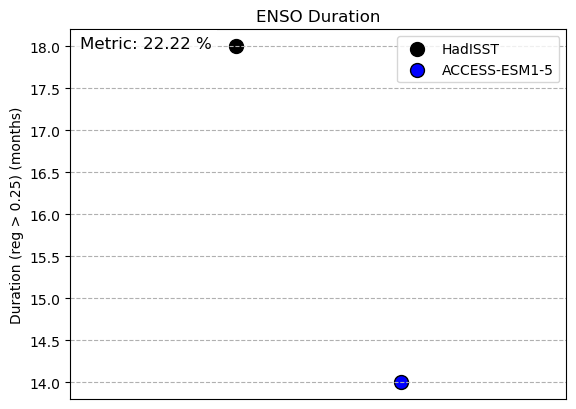

In [42]:
# Set x_position to represent the model (1, 2, or 3)
x_position = [1, 2]  # Change this to 1, 2, or 3 based on your requirement
label_array = ['HadISST', 'ACCESS-ESM1-5']

# Plot the HadISST duration point in black
plt.scatter(x_position[0], obs_model_count[0], color='black', edgecolor='black', s=100, marker='o', label=label_array[0])

# Plot the Model 2 duration point in blue
plt.scatter(x_position[1], obs_model_count[1], color='blue', edgecolor='black', s=100, marker='o', label=label_array[1])

plt.text(0.02, 0.95, f'Metric: {metric:.2f} %', fontsize=12, ha='left', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.xlim(0,3)
plt.xticks([])

# Add labels and title
# plt.xlabel('Model')
plt.ylabel('Duration (reg > 0.25) (months)')
plt.title('ENSO Duration')

# Optionally add a grid and legend
plt.grid(linestyle='--')

plt.legend()

# Show the plot
plt.show()


**Figure 1**: Duration of the ENSO life cycle where SSTA exceeds 0.25, illustrating the "duration" of the SSTA event. The model typically shows a duration close to the reference, but slightly longer. The black markers represent the reference data, while the blue markers represent the model output. The derived metric is the absolute relative difference, calculated as: \( \text{abs}((\text{model} - \text{ref}) / \text{ref}) \times 100 \).


## Diagnostic Level 2

The second level shows the temporal evolution of SSTA during ENSO: the ENSO life-cycle.

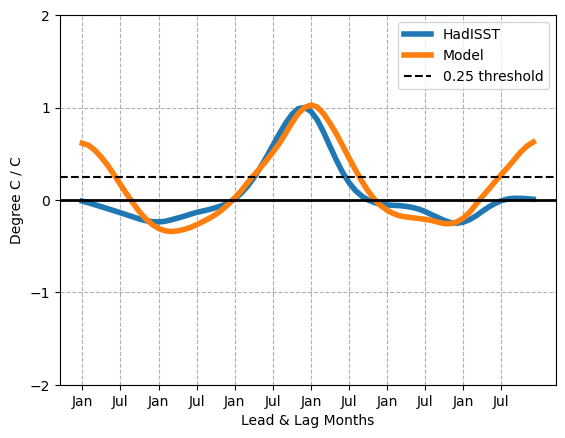

In [14]:
# Plot the slope
plt.plot(months, obs[0], label='HadISST', lw=4)
plt.plot(months, model[0], label='Model', lw=4)

# Draw a black dashed line at y=0.25
plt.axhline(y=0.25, color='black', linestyle='--', label='0.25 threshold')

# Draw a thicker line at y=0
plt.axhline(y=0, color='black', linewidth=2) #, label='Zero Line')

# Define custom ticks for the x-axis (every 6 months)
xticks = np.arange(1, 73, 6) - 36  # Adjust for lead/lag months
xtick_labels = ['Jan', 'Jul'] * (len(xticks) // 2)

# Set the labels and titles
plt.xlabel('Lead & Lag Months')
plt.ylabel('Degree C / C')
plt.legend()
plt.grid(linestyle='--')

# Apply the custom ticks and labels to the x-axis
plt.xticks(xticks, xtick_labels)
plt.yticks(np.arange(-2,2.5, step=1))

# Show the plot
plt.show()

**Figure 2**: Temporal structure of sea surface temperature anomalies (SSTA) in the central equatorial Pacific (Niño 3.4 region average), illustrating the temporal evolution of SSTA. The model typically exhibits an overly frequent oscillation between negative and positive SSTA phases. The black curve represents the reference data, while the blue curve corresponds to the model output.
